In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from pmdarima.arima import auto_arima

# What is ARIMA(p,d,q)?

As the name suggests, ARIMA is a combination of AR and MA models and order of integration.

* AR: autoregressive process says that the past values in the time series affect the present.
* MA: Moving average process indicates that the current value depends on the current and past error rates
* I: Differentiation is applied to obtain a stationary time series that does not show trend or seasonality.

All of these components create the parameters to be used by ARIMA(p,d,q).

* p: This p-value decides how far back we go. It is the lag order.
* d: It is equal to the number of times a series is differenced until it becomes stationary.
* q: This parameter determines the number of historical error terms that affect the current value

In fact, apart from the AR and MA models, the only new parameter here is the d parameter. In the diagram below, you can see how the data should be examined after receiving it.

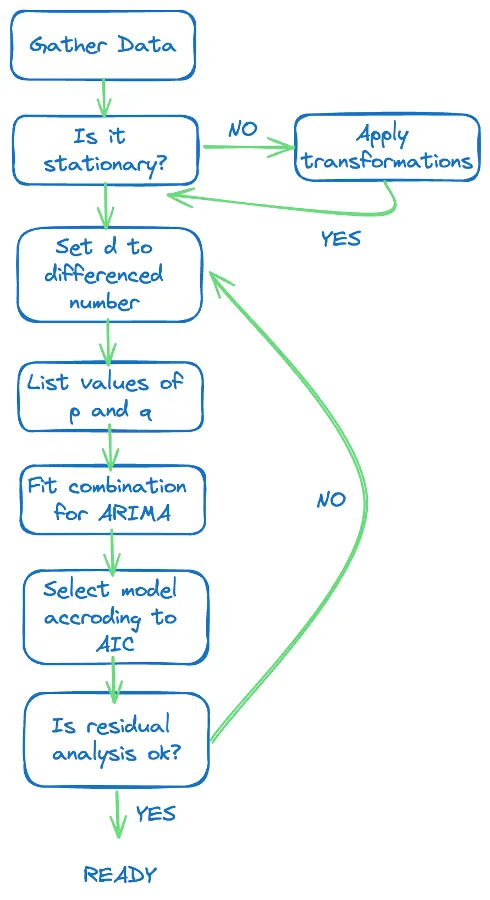

First of all, we need to pay attention to whether the data is stationary or not. After applying the transformations to make the data stationary (you can find them in the first article), we need to determine the d parameter of ARIMA. This parameter can also be determined by how many differencing we receive when making the data stationary. Later, in order to find the optimum values of the p and q parameters, we can create separate lists for both and try every combination of the 3 parameters with iteration. The model with the smallest AIC value can be selected as the best model. There is an important point here: if we want to compare models according to the AIC metric, the d parameter must be constant. The same d should be used in every model. After choosing the model, we should not say that this model is the best and leave it at that. Here we need to do a residual analysis for the model we chose. Residual analysis helps assess whether the model adequately captures the underlying patterns in the time series data.

# What is SARIMA(p,d,q)(P,D,Q)m?

The SARIMA model includes P, D, Q, m parameters in addition to ARIMA. These parameters help us capture seasonality.

* P: order of seasonal AR(P)
* D: seasonal order of integration
* Q: order of seasonal MA(Q)
* m: Number of observations per cycle (frequency)

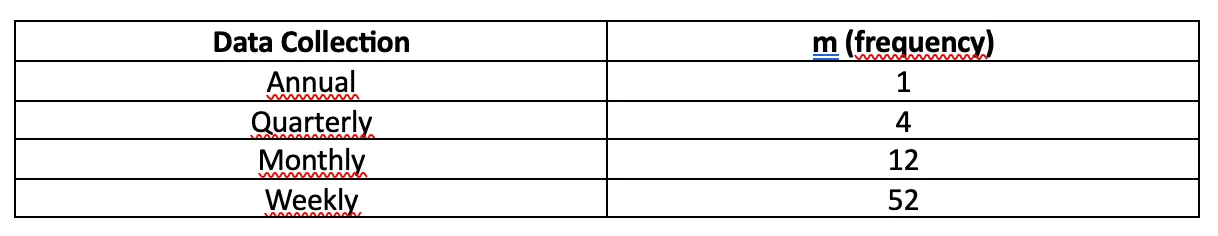

Note that a SARIMA(p,d,q)(0,0,0)m model is equivalent to an ARIMA(p,d,q) model.

# CODE PRACTICE

Now let’s do all this in practice. We will use auto_arima from the pmdarima library to determine the optimal model.

For examples we will use the air passengers dataset available on Kaggle.

This data set contains the number of passengers on a monthly basis. The data consists of 144 rows and 2 columns. There are monthly time periods between 1949–1960.

In [31]:
df = pd.read_csv("AirPassengers.csv")
df.rename(columns={"Month":"month","#Passengers":"passengers"}, inplace=True)
df.head()

,month,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [32]:
df.tail()

,month,passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


When we examine the graph of the number of passengers over time, we can clearly see that there is seasonality even here.

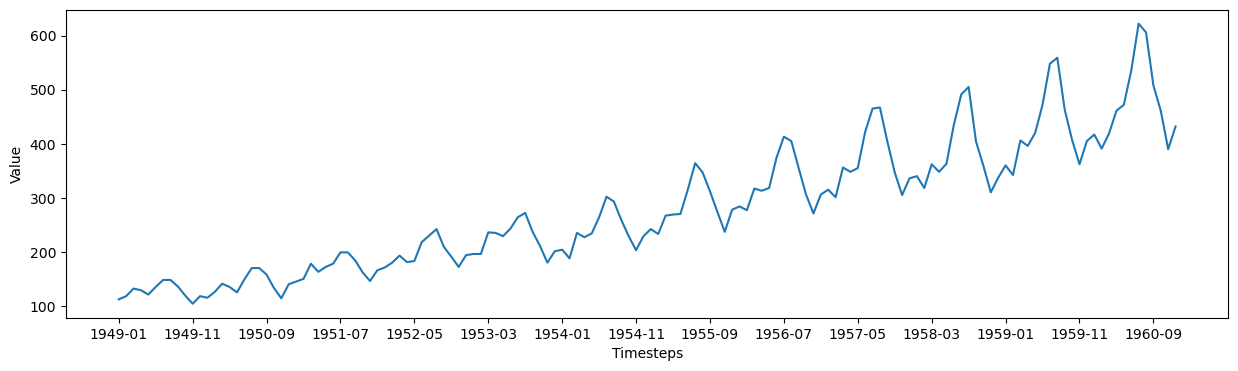

In [33]:
plt.figure(figsize=(15,4))
plt.plot(df["month"],df["passengers"]);
plt.xlabel('Timesteps');
plt.ylabel('Value');
plt.xticks(df['month'][::10]);

To see this more closely, we need to decompose the data.
When examining the graphs, an increasing trend can be observed. Additionally, there is seasonality in the data. If there were no seasonality in the data, the “Seasonal” graph would continue as a straight line starting from 0.

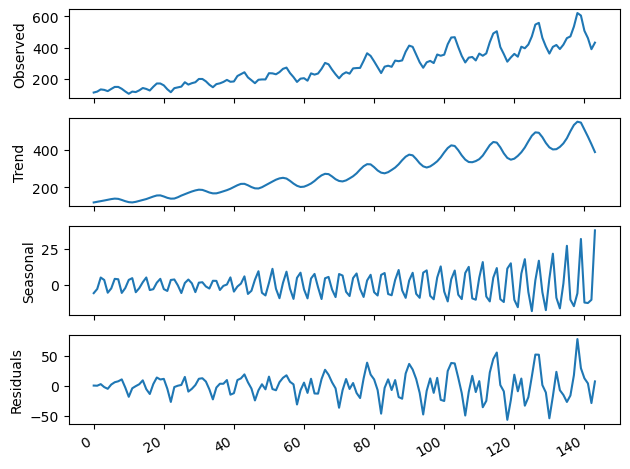

In [34]:
# Decomposition

advanced_decomposition = STL(df.passengers, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

We must apply the Dickey-Fuller test to decide whether the data is stationary or not.

* Null Hypothesis: Data is non-stationary
* Alternative Hypothesis: Data is stationary

In [35]:
def adfuller_test(y):
    adf_result = adfuller(y)

    print("ADF Statistic:", adf_result[0])
    print("P-Value:", adf_result[1])

adfuller_test(df.passengers)

ADF Statistic: 0.8153688792060371
P-Value: 0.9918802434376408


When we apply the Dickey-Fuller test to the “Passengers” variable, we can see that the p-value is greater than 0.05, meaning the data is not stationary. We can perform differencing to make the data stationary.

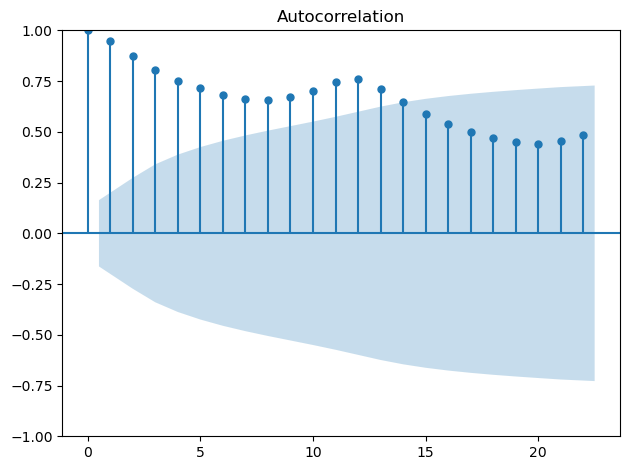

In [36]:
plot_acf(df.passengers)
plt.tight_layout()

First order differencing did not make the data stationary. P-value is still greater than 0.05 so we perform differencing again. The second time the data became stationary. Thus, we determined that our d parameter should be 2.

In [37]:
df_diff = np.diff(df['passengers'], n=1)
adfuller_test(df_diff)

print("*"*50)

df_diff2 = np.diff(df_diff, n=1)
adfuller_test(df_diff2)

# d = 2

ADF Statistic: -2.829266824169981
P-Value: 0.05421329028382792
**************************************************
ADF Statistic: -16.384231542468505
P-Value: 2.7328918500142407e-29


We divide the data into two: train and test. We put 12 months of data to the test.

In [38]:
train = df[:-12]
test = df[-12:]

Now we will create an ARIMA model using auto_arima. auto_arima makes it easy for us to find the optimum parameters. It reduces the workload because it performs the iterations itself. If you wish, you can create your own function with for lobs without using this library.

Model parameters:

* Training data (train[“passengers”]: First, we give the data we want to train. Since the data we will be predicting is passengers, we give the passengers variable in the train data to the model.
* start_p: At what number should we start searching for the p value for the AR(p) part?
* start_q: At what number should we start searching for the q value for the MA(q) part?
* test=’adf’: use adftest to find optimal ‘d’
* max_p: The maximum value that the p parameter can take.
* max_q: The maximum value that the q parameter can take.
* m:frequency. If it is 1, we say there is no seasonality.
* d: order of integration
* seasonal: is there seasonality or not?

When we run the model, we can see that the best parameters it finds are SARIMAX(4, 2, 0). The reason why it is shown as SARIMAX is because auto_arima can also run the SARIMAX model. Since these models are already separated by parameters, the SARIMAX(4, 2, 0) representation is equal to the ARIMA(4, 2, 0) representation.

In [39]:
ARIMA_model = auto_arima(train['passengers'], 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      tr=13, max_q=13, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=2,
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=True, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
ARIMA_model.summary()

Performing stepwise search to minimize aic


 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1313.912, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=1310.149, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1311.919, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1304.913, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1302.281, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=1282.663, Time=0.05 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=1283.722, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=1280.672, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=1300.282, Time=0.03 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=1281.732, Time=0.05 sec
 ARIMA(4,2,1)(0,0,0)[0]            

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(4, 2, 0)   Log Likelihood                -635.336
Date:                Sat, 06 Jan 2024   AIC                           1280.672
Time:                        22:56:19   BIC                           1295.010
Sample:                             0   HQIC                          1286.498
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3718      0.114     -3.254      0.001      -0.596      -0.148
ar.L2         -0.4099      0.098     -4.172      0.000      -0.602      -0.217
ar.L3         -0.3116      0.075     -4.144      0.000      -0.459      -0.164
ar.L4         -0.4083      0.082     -4.974      0.000      -0.569      -0.247
sigma2      1021.2813    110.979      9.202      0.000     803.767    1238.796
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 5.44
Prob(Q):                              0.68   Prob(JB):                         0.07
Heteroskedasticity (H):               7.55   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can visualize the residual analysis of the resulting model as follows.

* Standardized Residual: There is no obvious pattern in the residuals, with values having zero mean and uniform variance.
* Histogram plus: The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)
* Q-Q Plot: Most of the data points should lie on the straight line
* Correlogram (ACF plot): There should be no significant autocorrelation coefficients after lag 0, but we have.

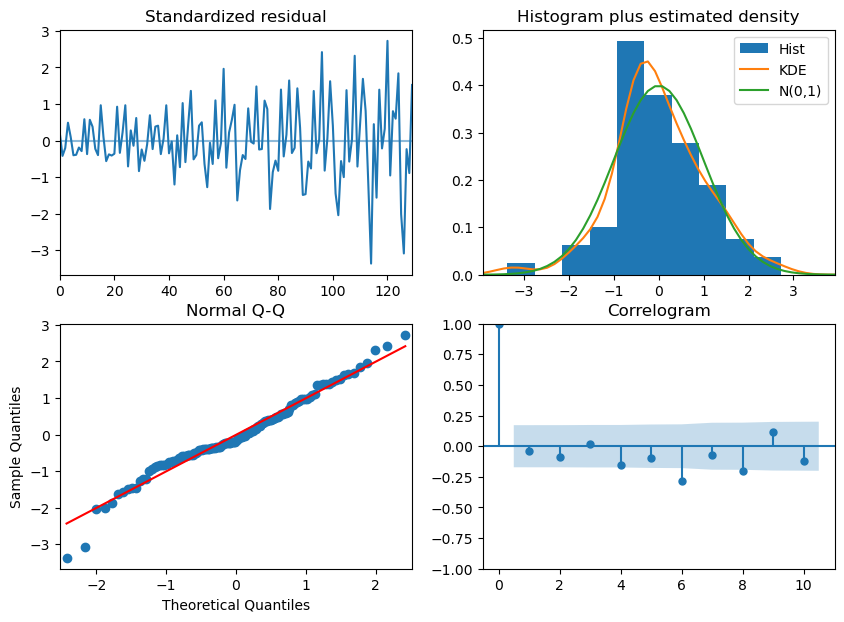

In [40]:
ARIMA_model.plot_diagnostics(figsize=(10,7))
plt.show()

The next step is to run the Ljung-Box test on the residuals to make sure that they are independent and uncorrelated.
Here we expect all p-value values to be greater than 0.05. But the values we obtained are not like this.

In [41]:
ARIMA_model = SARIMAX(train["passengers"], order=(4,2,0), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

residuals = ARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1)) 

,lb_stat,lb_pvalue
1,0.708981,0.399782
2,1.326045,0.515291
3,1.330827,0.721826
4,4.287459,0.368498
5,4.995811,0.416392
6,13.706529,0.033092
7,14.382274,0.044785
8,19.392139,0.012897
9,20.837768,0.013391
10,23.084013,0.010441


To compare the ARIMA and SARIMA models, we will add the predictions of both to the test data. “naive_seasonal” treats the values of the last 12 months as the same as the 12 months in the test data we want to predict. So we assume the last 2 years are the same. ARIMA_pred contains the values of the last 12 months predicted by the model.

In [42]:
test['naive_seasonal'] = df['passengers'].iloc[120:132].values
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['ARIMA_pred'] = ARIMA_pred

/var/folders/fx/sfm1r3x51czb__n2j19fryw00000gn/T/ipykernel_6483/3940874971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['passengers'].iloc[120:132].values
/var/folders/fx/sfm1r3x51czb__n2j19fryw00000gn/T/ipykernel_6483/3940874971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


# SARIMA

In the SARIMA model, we first need to look at differencing. As we know from ARIMA, first order differencing was not enough to make the data stationary.

Here we first take first order differencing. Since the data is not stationary, we do this process again, but we write 12 (frequency of the data — m parameter) instead of 1 in the n parameter. As a result, we can see that the data is stationary and the parameters are:

* d = 1
* D = 1

In [43]:
df_diff = np.diff(df['passengers'], n=1)
adfuller_test(df_diff)
print("*"*50)

#Seasonal differencing. Since we have monthly data, 
# m = 12, so the seasonal difference is the difference between two values that are 12 timesteps apart.
df_diff2 = np.diff(df_diff, n=12)
adfuller_test(df_diff2)

# Therefore, we performed one round of differencing, meaning that d = 1, and one round of seasonal differencing, meaning that D = 1.

ADF Statistic: -2.829266824169981
P-Value: 0.05421329028382792
**************************************************
ADF Statistic: -17.624862360089335
P-Value: 3.82304685629587e-30


We use some extra parameters when using SARIMA.

* start_P, start_Q: Initial value of P and Q parameters to be used in SARIMA
* max_P, max_Q: Maximum value of P and Q parameters to be used in SARIMA
* D: differencing order for SARIMA
* m: Since we have seasonality, we must replace this parameter with the frequency of the data.
* Seasonal: must be True since there is seasonality

As a result, the best model was found to be SARIMAX(1, 1, 0)x(0, 1, 0, 12).

When we examine the residual analysis of this;



In [44]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = auto_arima(train["passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, 
                         m=12, #12 is the frequncy of the cycle
                         start_P=1, start_Q=1,
                         max_P = 5, max_Q=5, 
                         seasonal=True, #set to seasonal
                         d=1, 
                         D=1,
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
SARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -447.951
Date:                            Sat, 06 Jan 2024   AIC                            899.902
Time:                                    22:56:24   BIC                            905.460
Sample:                                         0   HQIC                           902.159
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2431      0.090     -2.697      0.007      -0.420      -0.066
sigma2       108.8757     13.306      8.183      0.000      82.797     134.954
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.57
Prob(Q):                              0.89   Prob(JB):                         0.75
Heteroskedasticity (H):               1.47   Skew:                            -0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Standardized Residual: shows that the residuals do not exhibit a trend or a change in variance.
* Histogram plus: residuals’ distribution is very close to a normal distribution.
* Q-Q Plot: Most of the data points should lie on the straight line, which displays a fairly straight line
* Correlogram (ACF plot): hows no significant coefficients after lag 0. Therefore, everything leads to the conclusion that the residuals resemble white noise.

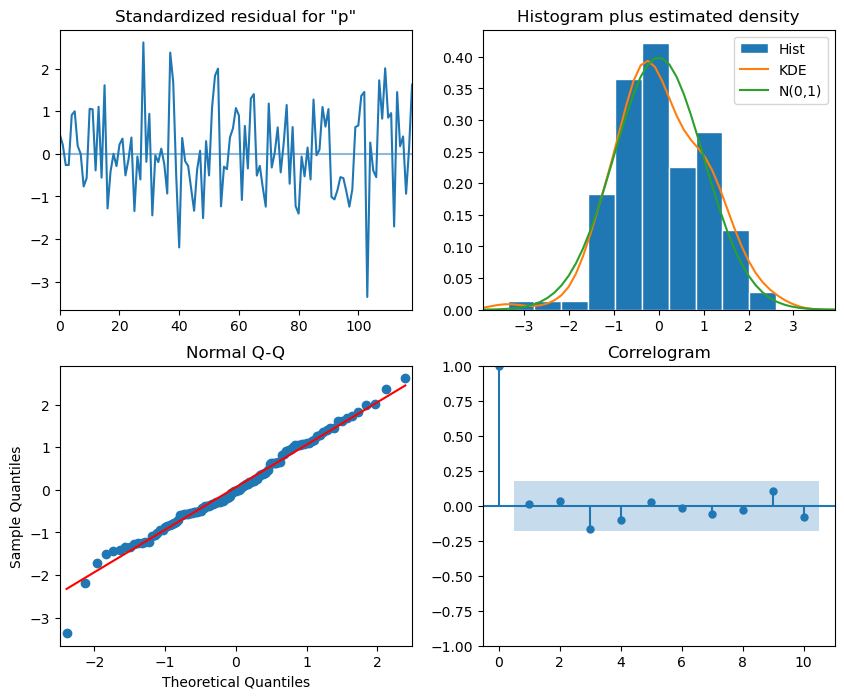

In [45]:
SARIMA_model = SARIMAX(train["passengers"], order=(1,1,0), seasonal_order=(0,1,0,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

To verify this, we will also perform the Ljung-Box test.
The returned p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.
Our model has passed all the tests from the residuals analysis, and we are ready to use it for forecasting.



In [46]:
residuals = SARIMA_model_fit.resid
acorr_ljungbox(residuals, np.arange(1, 11, 1))

,lb_stat,lb_pvalue
1,0.002247,0.962190
2,0.821280,0.663226
3,1.304629,0.728034
4,1.652892,0.799256
5,2.000348,0.849097
6,2.013761,0.918429
7,2.541900,0.923909
8,3.022004,0.932969
9,3.023712,0.963347
10,4.927705,0.895955


The returned p-values are all greater than 0.05. Therefore, we do not reject the null hypothesis, and we conclude that the residuals are independent and uncorrelated, just like white noise.
Our model has passed all the tests from the residuals analysis, and we are ready to use it for forecasting

In [47]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test['SARIMA_pred'] = SARIMA_pred

/var/folders/fx/sfm1r3x51czb__n2j19fryw00000gn/T/ipykernel_6483/3842401883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


We can visualize the results of both models and observe which one gives results closer to reality.

The gray area in the graph above is our test data. The blue line shows the actual values. When we examine the results, we can say that ARIMA’s success is very low, but SARIMA is successful in its predictions. The addition of seasonality has been successful for the model.



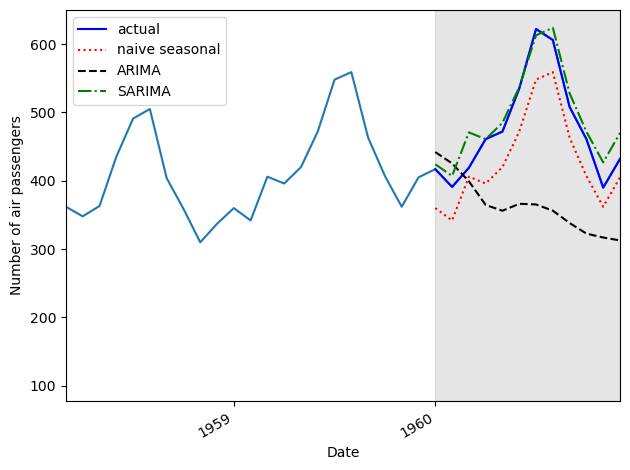

In [48]:
fig, ax = plt.subplots()

ax.plot(df['month'], df['passengers'])
ax.plot(test['passengers'], 'b-', label='actual') 
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal') 
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA') 
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(110, 143)
fig.autofmt_xdate()
plt.tight_layout()

We can also evaluate the success of the model with MAPE (Mean Absolute Percentage Error). Here we expect MAPE to be small.

When we examine the metric, we can see that the best model is the SARIMA model.

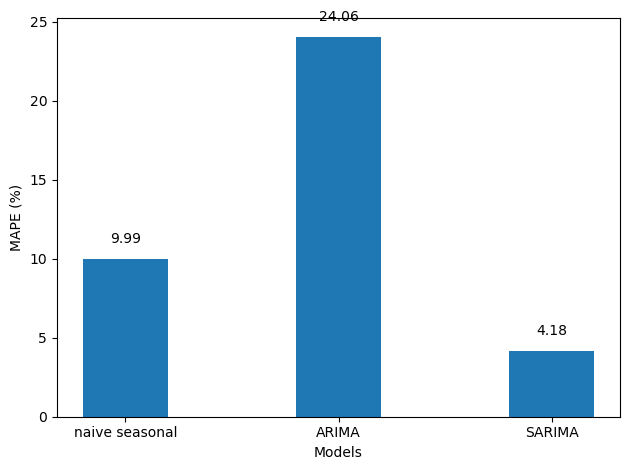

In [49]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_naive_seasonal = mape(test['passengers'], test['naive_seasonal']) 
mape_ARIMA = mape(test['passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['passengers'], test['SARIMA_pred'])
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA', 'SARIMA'] 
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    plt.tight_layout()